## Sentiment Analysis on Amazon Data Science Book Reviews

### Exploratory Data Analysis

In [1]:
#Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn import metrics
#from sklearn.metrics import plot_roc_curve
#import scikitplot as skplt


from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Read the dataset
data = pd.read_csv("/content/drive/MyDrive/Amazon Books Reviews Dataset/reviews.csv")

In [ ]:
#Lets have a look at dataset
data.head()

,stars,comment,book_url
0,5.0,"Let me say at the outset of this review, that ...",https://www.amazon.com/dp/1492041130
1,1.0,Its Capitalism at its best. I read the book fr...,https://www.amazon.com/dp/1492041130
2,5.0,If you're looking to get started with data sci...,https://www.amazon.com/dp/1492041130
3,4.0,"In general, this is a good book. It covers a w...",https://www.amazon.com/dp/1492041130
4,5.0,I was an academic data scientist decades befor...,https://www.amazon.com/dp/1492041130


In [ ]:
data.shape

(20647, 3)

In [ ]:
# Lets remove book_url column as we dont need it for analysis of reviews
data.drop(['book_url'],axis=1, inplace=True)

In [ ]:
data.head()

,stars,comment
0,5.0,"Let me say at the outset of this review, that ..."
1,1.0,Its Capitalism at its best. I read the book fr...
2,5.0,If you're looking to get started with data sci...
3,4.0,"In general, this is a good book. It covers a w..."
4,5.0,I was an academic data scientist decades befor...


In [ ]:
# Check for null values
data.isnull().sum()

stars      0
comment    0
dtype: int64

###### Null values are not present in data

In [ ]:
# Check for duplicates
data[data.duplicated()]

,stars,comment
191,5.0,Good
395,5.0,good
594,5.0,good
757,5.0,I bought this book for understanding the term ...
786,5.0,very good
...,...,...
20544,5.0,Very helpful
20545,5.0,Great product
20551,5.0,Good read
20632,5.0,very good


###### There are 1026 duplicate reviews/comments

In [ ]:
# Lets remove duplicates
# Drop duplicates and keep the first occurence of the review
data.drop_duplicates(keep='first', inplace=True)

In [ ]:
# Shape of data after dropping duplicates
data.shape

(19621, 2)

In [ ]:
# Lets create a new feature sentiment based on number of stars
sentiments = []
for star in data['stars'].tolist():
  if star > 3.0:
    sentiments.append(1)
  else:
    sentiments.append(0)
data['sentiment'] = sentiments

<Axes: xlabel='sentiment', ylabel='count'>

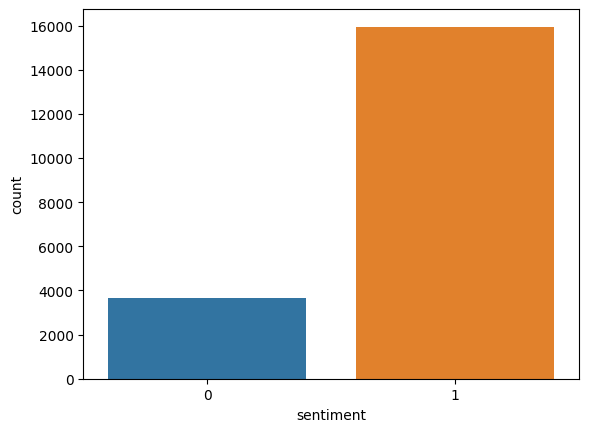

In [ ]:
# Lets check number of values for each category of stars
sns.countplot(x=data["sentiment"])

### Text Pre-processing

In [ ]:
# Lets do pre-processing on comments
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
def preprocess_comment(comment):
    comment = re.sub('[^a-zA-Z]',' ', comment)
    comment = comment.lower()
    comment = [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(comment) if word not in set(stopwords.words('english'))]
    clean_comment = ' '.join(comment)
    return clean_comment
   

In [ ]:
# Comment before preprocessing
data['comment'].iloc[2]

"If you're looking to get started with data science but you're confused on which material to use...videos, books, a specific online class, etc...start with this book and see where it takes you. This book will give you a great place to start and afterwards, you will have enough knowledge to make an educated choice on what educational resource to use next."

In [ ]:
# Comment after preprocessing
preprocess_comment(data['comment'].iloc[2])

'looking get started data science confused material use video book specific online class etc start book see take book give great place start afterwards enough knowledge make educated choice educational resource use next'

### Split Data into training and testing data

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data['comment'], data['sentiment'], stratify =  data['sentiment'], test_size= 0.2, random_state=42)

In [ ]:
x_train.shape

(15696,)

In [ ]:
x_test.shape

(3925,)

In [ ]:
y_train.value_counts()

1    12760
0     2936
Name: sentiment, dtype: int64

In [ ]:
y_test.value_counts()

1    3191
0     734
Name: sentiment, dtype: int64

### Text Vectorization Using TF-IDF

In [ ]:
# Creating vectors for train and test data using tf-idf with the custom tokenizer that we defined earlier
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(tokenizer = preprocess_comment, max_features=10000,ngram_range=(1, 3),max_df=0.7)
X_train = cv.fit_transform(x_train)
X_test = cv.transform(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Using SMOTE to handle class imbalance in training data

In [ ]:
# Using SMOTE to increase the number of samples in minority class.
# Sampling_strategy = 0.75 corresponds to the desired ratio of the number of samples in the minority class 
# over the number of samples in the majority class after resampling

over = SMOTE(sampling_strategy=0.75)
X_train, y_train = over.fit_resample(X_train, y_train)

In [ ]:
X_train.shape

(22330, 8784)

In [ ]:
y_train.value_counts()

1    12760
0     9570
Name: sentiment, dtype: int64

In [ ]:
# Using randomundersampling to reduce number samples from majority class so that we could get balanced data
under = RandomUnderSampler(sampling_strategy=1)
X_train, y_train = under.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

0    9570
1    9570
Name: sentiment, dtype: int64

### Defining some utility functions

In [18]:
f1_score_train = {}
f1_score_test = {}
tpr_test = {}
fpr_test = {}
auc_training = {}
auc_test = {}

In [19]:
from mlxtend.plotting import plot_confusion_matrix
def model_perf_plots(y_true,y_pred, fpr,tpr,fpr_train,tpr_train, auc,auc_train):
  f, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].set_title('Confusion Matrix')
  confusion_matrix = metrics.confusion_matrix(y_true,y_pred)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['negative', 'positive'])
  cm_display.plot(ax=axes[0])
  cm_display.ax_.set_xlabel('Predictions', fontsize=9)
  cm_display.ax_.set_ylabel('Actuals', fontsize=9)
  
  axes[1].set_title('ROC Curve')
  #create ROC curve
  axes[1].plot(fpr,tpr,label="Test AUC="+str(auc))
  axes[1].plot(fpr_train,tpr_train,label="Train AUC="+str(auc_train))
  axes[1].set_ylabel('True Positive Rate')
  axes[1].set_xlabel('False Positive Rate')
  axes[1].legend(loc=4)

  plt.subplots_adjust(wspace=0.50, hspace=0.1)
  plt.show()





In [10]:
def evaluate_model(X_train, y_train,X_test,y_test,model,param):
  gs = GridSearchCV(model,param,cv=3)
  gs.fit(X_train.toarray(),y_train)

  model.set_params(**gs.best_params_)
  model.fit(X_train.toarray(),y_train)
  y_train_pred = model.predict(X_train.toarray())
  y_train_pred_proba = model.predict_proba(X_train.toarray())
  y_test_pred = model.predict(X_test.toarray())
  y_test_pred_proba = model.predict_proba(X_test.toarray())

  return model ,y_train_pred,y_train_pred_proba, y_test_pred, y_test_pred_proba

In [ ]:
from sklearn import metrics
def plot_confusion_matrix(y_actual, y_pred):
  confusion_matrix = metrics.confusion_matrix(y_actual, y_pred)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['negative', 'positive'])
  cm_display.plot()
  plt.show()



### Guassian Naive Bayes

F1 score of model GaussianNB(var_smoothing=0.01) on training data is 0.806179088176974
F1 score of model GaussianNB(var_smoothing=0.01) on test data is 0.6900468281653562


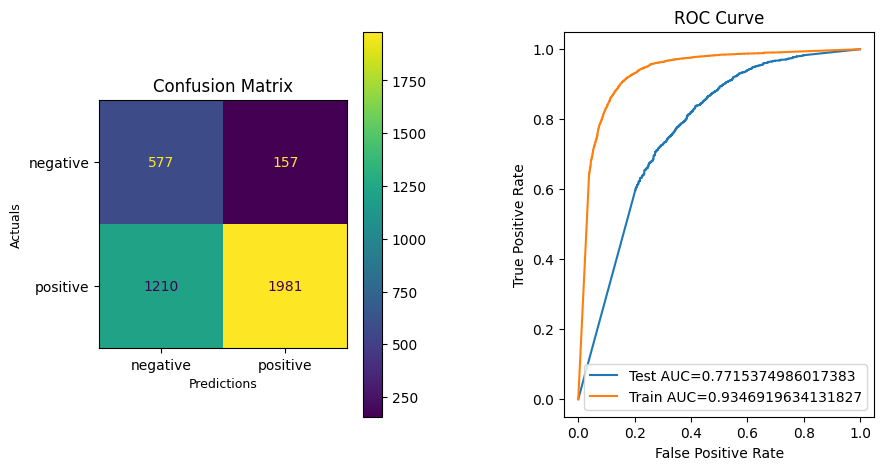

In [ ]:
model  = GaussianNB()
param = { 'var_smoothing': [0.001,0.005,0.01,0.03,0.05]}

model ,y_train_pred,y_train_pred_proba, y_test_pred, y_test_pred_proba = evaluate_model(X_train, y_train,X_test,y_test,model,param)

fpr,tpr,_ = roc_curve(y_test, y_test_pred_proba[:,1])
fpr_train,tpr_train,_ = roc_curve(y_train, y_train_pred_proba[:,1])

auc = roc_auc_score(y_test, y_test_pred_proba[:,1])
auc_train = roc_auc_score(y_train, y_train_pred_proba[:,1])

f1_score_train[model] =  f1_score(y_train, y_train_pred, average='weighted')
print("F1 score of model {} on training data is {}".format(model, f1_score_train[model]))

f1_score_test[model] =  f1_score(y_test, y_test_pred, average='weighted')
print("F1 score of model {} on test data is {}".format(model, f1_score_test[model]))

tpr_test[model] = tpr
fpr_test[model] = fpr
auc_test[model] = auc
auc_training[model] = auc_train

model_perf_plots(y_test,y_test_pred, fpr,tpr, fpr_train,tpr_train,auc,auc_train)

#plot_confusion_matrix(y_test, y_test_pred)
#plt.plot(fpr, tpr)
#plt.show()


### Decision Tree

F1 score of model DecisionTreeClassifier(class_weight='balanced', max_depth=25,
                       max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=15) on training data is 0.8601764870162127
F1 score of model DecisionTreeClassifier(class_weight='balanced', max_depth=25,
                       max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=15) on test data is 0.7172037581277599


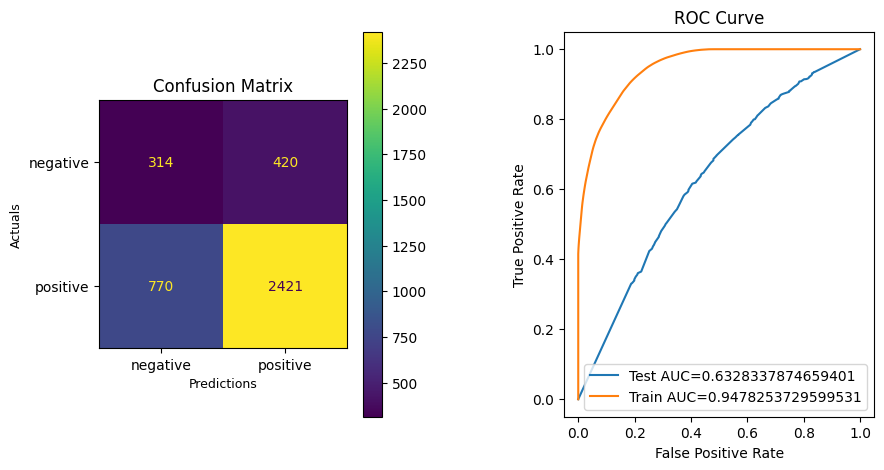

In [ ]:
model  = DecisionTreeClassifier(class_weight = "balanced", max_features='log2')
param = { 'max_depth' : [10,15,20,25],
           'min_samples_leaf' : [3,5,10,15,20],
          'min_samples_split' : [5,8,10,15,20],
         'max_features': ['sqrt','log2']}


model ,y_train_pred,y_train_pred_proba, y_test_pred, y_test_pred_proba = evaluate_model(X_train, y_train,X_test,y_test,model,param)

fpr,tpr,_ = roc_curve(y_test, y_test_pred_proba[:,1])
fpr_train,tpr_train,_ = roc_curve(y_train, y_train_pred_proba[:,1])

auc = roc_auc_score(y_test, y_test_pred_proba[:,1])
auc_train = roc_auc_score(y_train, y_train_pred_proba[:,1])

f1_score_train[model] =  f1_score(y_train, y_train_pred, average='weighted')
print("F1 score of model {} on training data is {}".format(model, f1_score_train[model]))

f1_score_test[model] =  f1_score(y_test, y_test_pred, average='weighted')
print("F1 score of model {} on test data is {}".format(model, f1_score_test[model]))

tpr_test[model] = tpr
fpr_test[model] = fpr
auc_test[model] = auc
auc_training[model] = auc_train

model_perf_plots(y_test,y_test_pred, fpr,tpr, fpr_train,tpr_train,auc,auc_train)

### Random Forest Classifier

F1 score of model RandomForestClassifier(class_weight='balanced_subsample', max_features='log2',
                       max_samples=0.5, min_samples_split=5, n_estimators=120,
                       oob_score=True, random_state=30) on training data is 0.9937302688957953
F1 score of model RandomForestClassifier(class_weight='balanced_subsample', max_features='log2',
                       max_samples=0.5, min_samples_split=5, n_estimators=120,
                       oob_score=True, random_state=30) on test data is 0.7796541598259479


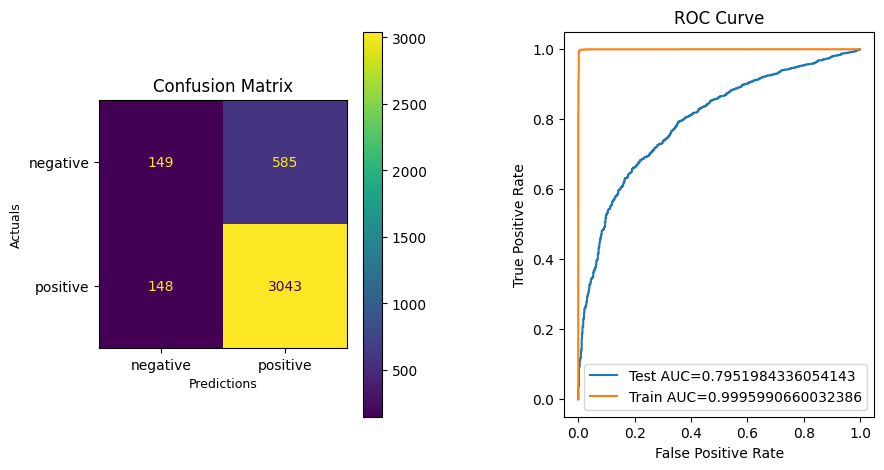

In [ ]:
model  = RandomForestClassifier(class_weight='balanced_subsample',random_state = 30,oob_score=True,max_features='log2')
param = { 'n_estimators': [30,50,75,100,120], 'max_samples' : [0.2,0.3,0.5],'min_samples_split' : [5,8,10,15,20]}

model ,y_train_pred,y_train_pred_proba, y_test_pred, y_test_pred_proba = evaluate_model(X_train, y_train,X_test,y_test,model,param)

fpr,tpr,_ = roc_curve(y_test, y_test_pred_proba[:,1])
fpr_train,tpr_train,_ = roc_curve(y_train, y_train_pred_proba[:,1])

auc = roc_auc_score(y_test, y_test_pred_proba[:,1])
auc_train = roc_auc_score(y_train, y_train_pred_proba[:,1])

f1_score_train[model] =  f1_score(y_train, y_train_pred, average='weighted')
print("F1 score of model {} on training data is {}".format(model, f1_score_train[model]))

f1_score_test[model] =  f1_score(y_test, y_test_pred, average='weighted')
print("F1 score of model {} on test data is {}".format(model, f1_score_test[model]))

tpr_test[model] = tpr
fpr_test[model] = fpr
auc_test[model] = auc
auc_training[model] = auc_train

model_perf_plots(y_test,y_test_pred, fpr,tpr, fpr_train,tpr_train,auc,auc_train)

### XG-BOOST Classifier

F1 score of model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=15, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) on training data is 0.9158473079970177
F1 score of model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_r

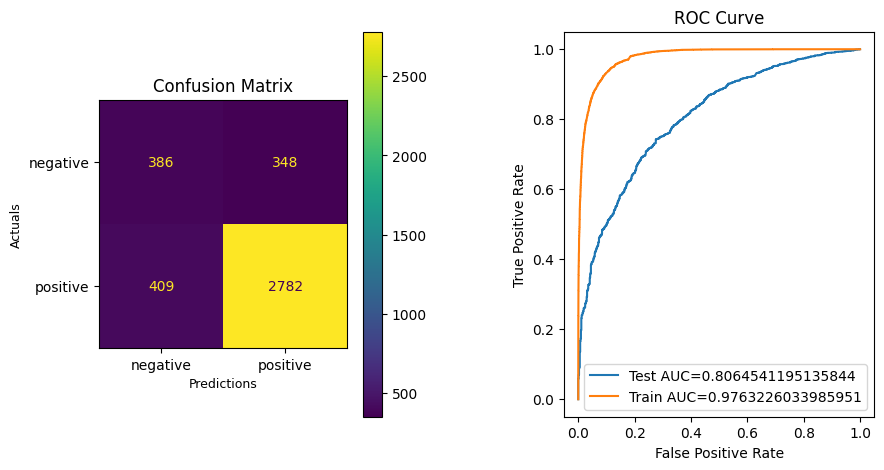

In [ ]:
import xgboost as xgb
model  = xgb.XGBClassifier()
param = { 'n_estimators': [15], 'learning_rate':[0.5]}

model ,y_train_pred,y_train_pred_proba, y_test_pred, y_test_pred_proba = evaluate_model(X_train, y_train,X_test,y_test,model,param)

fpr,tpr,_ = roc_curve(y_test, y_test_pred_proba[:,1])
fpr_train,tpr_train,_ = roc_curve(y_train, y_train_pred_proba[:,1])

auc = roc_auc_score(y_test, y_test_pred_proba[:,1])
auc_train = roc_auc_score(y_train, y_train_pred_proba[:,1])

f1_score_train[model] =  f1_score(y_train, y_train_pred, average='weighted')
print("F1 score of model {} on training data is {}".format(model, f1_score_train[model]))

f1_score_test[model] =  f1_score(y_test, y_test_pred, average='weighted')
print("F1 score of model {} on test data is {}".format(model, f1_score_test[model]))

tpr_test[model] = tpr
fpr_test[model] = fpr
auc_test[model] = auc
auc_training[model] = auc_train

model_perf_plots(y_test,y_test_pred, fpr,tpr, fpr_train,tpr_train,auc,auc_train)


### Logistic Regression

F1 score of model LogisticRegression(C=2, max_iter=150) on training data is 0.8982841270746192
F1 score of model LogisticRegression(C=2, max_iter=150) on test data is 0.8431705058875874


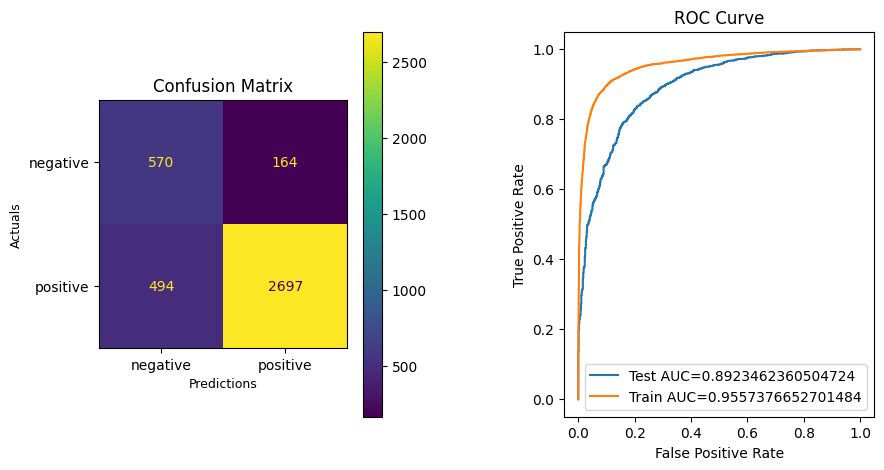

In [13]:
model  = LogisticRegression(max_iter=150)
param = { 'C' : [0.5,1,2]}

model ,y_train_pred,y_train_pred_proba, y_test_pred, y_test_pred_proba = evaluate_model(X_train, y_train,X_test,y_test,model,param)

fpr,tpr,_ = roc_curve(y_test, y_test_pred_proba[:,1])
fpr_train,tpr_train,_ = roc_curve(y_train, y_train_pred_proba[:,1])

auc = roc_auc_score(y_test, y_test_pred_proba[:,1])
auc_train = roc_auc_score(y_train, y_train_pred_proba[:,1])

f1_score_train[model] =  f1_score(y_train, y_train_pred, average='weighted')
print("F1 score of model {} on training data is {}".format(model, f1_score_train[model]))

f1_score_test[model] =  f1_score(y_test, y_test_pred, average='weighted')
print("F1 score of model {} on test data is {}".format(model, f1_score_test[model]))

tpr_test[model] = tpr
fpr_test[model] = fpr
auc_test[model] = auc
auc_training[model] = auc_train

model_perf_plots(y_test,y_test_pred, fpr,tpr, fpr_train,tpr_train,auc,auc_train)

### Compare F1 score on train and test data for different classifiers

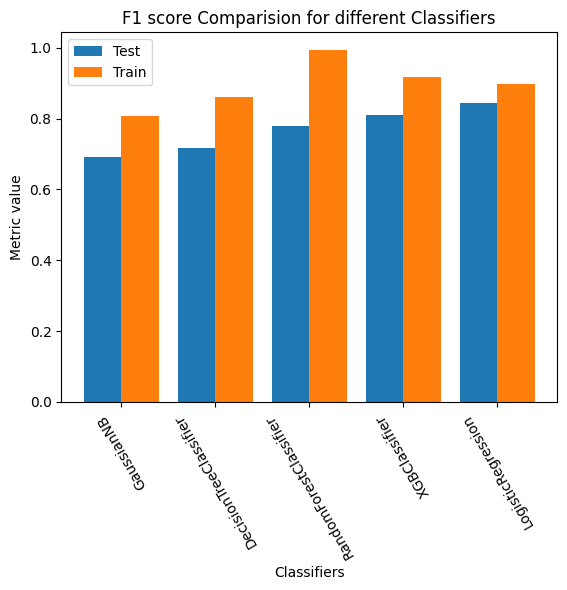

In [16]:
import numpy as np 
import matplotlib.pyplot as plt 
  
clfs = ['GaussianNB','DecisionTreeClassifier','RandomForestClassifier','XGBClassifier','LogisticRegression']
test_f1_score = list(f1_score_test.values())
train_f1_score = list(f1_score_train.values())
  
X_axis = np.arange(len(clfs))
  
plt.bar(X_axis - 0.2, test_f1_score, 0.4, label = 'Test')
plt.bar(X_axis + 0.2, train_f1_score, 0.4, label = 'Train')
  
plt.xticks(X_axis, clfs,rotation = 120)
plt.xlabel("Classifiers")
plt.ylabel("Metric value")
plt.title("F1 score Comparision for different Classifiers")
plt.legend()
plt.show()

### Compare AUC on train and test data for different classifiers

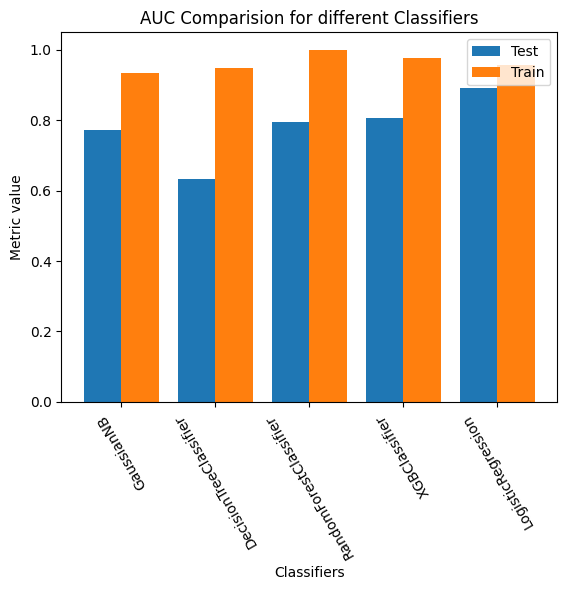

In [17]:
import numpy as np 
import matplotlib.pyplot as plt 
  
clfs = ['GaussianNB','DecisionTreeClassifier','RandomForestClassifier','XGBClassifier','LogisticRegression']
test_auc = list(auc_test.values())
train_auc = list(auc_training.values())
  
X_axis = np.arange(len(clfs))
  
plt.bar(X_axis - 0.2, test_auc, 0.4, label = 'Test')
plt.bar(X_axis + 0.2, train_auc, 0.4, label = 'Train')
  
plt.xticks(X_axis, clfs,rotation = 120)
plt.xlabel("Classifiers")
plt.ylabel("Metric value")
plt.title("AUC Comparision for different Classifiers")
plt.legend()
plt.show()

Observations:
1. Logistic Regression and XG-Boost are performing well on training and testing data. Both these models are generating more number of true positives as well as true negatives as compared to other models.

2. Decision Tree and Random Forest models are able to classify true positives but could not perform well while classifying true negatives.